In [1]:
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings 

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


ROOT = Path.cwd().parent
DATA = ROOT / "data"


sys.path.append(str(ROOT / "functions"))
from utils import * 
from num_functions import *

Data import

In [2]:
train_path = DATA / "train_merged.csv"
df = pd.read_csv(train_path, low_memory=False)
print(f"Total shape: {df.shape}")

# TransactionDT'ye göre sırala ve son %20'yi test olarak ayır
df = df.sort_values('TransactionDT').reset_index(drop=True)
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Train TransactionDT range: {train_df['TransactionDT'].min()} - {train_df['TransactionDT'].max()}")
print(f"Test TransactionDT range: {test_df['TransactionDT'].min()} - {test_df['TransactionDT'].max()}")

Total shape: (590540, 434)
Train shape: (472432, 434)
Test shape: (118108, 434)
Train TransactionDT range: 86400 - 12192842
Test TransactionDT range: 12192900 - 15811131


In [3]:
train_df = reduce_mem_usage(train_df.copy())
test_df = reduce_mem_usage(test_df.copy())

Memory usage decreased to 505.96 Mb (67.7% reduction)
Memory usage decreased to 128.29 Mb (67.2% reduction)


#### Missing Values

Elimizdeki veri sentetik değil , ufak bir değişiklik bile asıl pattern i bozabilir haliyle eksik değerler için çoğunluğu eksik olan sütunların silinmesi kalanlar içi nde doldurma yöntemlerinin iyice değerlendirilmesi gerekmektedir.

In [4]:
threshold = 95 # %95 ten fazlası eksik olan feature lar modele 
high_missing = top_missing_cols(train_df, thresh=threshold)
cols_to_drop = high_missing[high_missing['missing_percent'] > threshold]['col'].tolist()

train_df = train_df.drop(columns=cols_to_drop)
print(f" Threshold : {threshold}%\n Dropped feature num : {len(cols_to_drop)}")

test_df = test_df.drop(columns=[c for c in cols_to_drop if c in test_df.columns])
# Features with missing values exceeding the 95% threshold were dropped.

There are 414 columns with missing values.
There are 9 columns with missing percent > 95%
 Threshold : 95%
 Dropped feature num : 9


# Target Anlysis

The target variable "isFraud" is a binary variable and represents whether the record is involved in fraudulent activity.

Approximately 3.5% of train data has a value of “isFraud = 1”. 

Class distribution for 'isFraud':
isFraud
0    455833
1     16599
Name: count, dtype: int64

Percentage:
isFraud
0    0.964865
1    0.035135
Name: proportion, dtype: float64


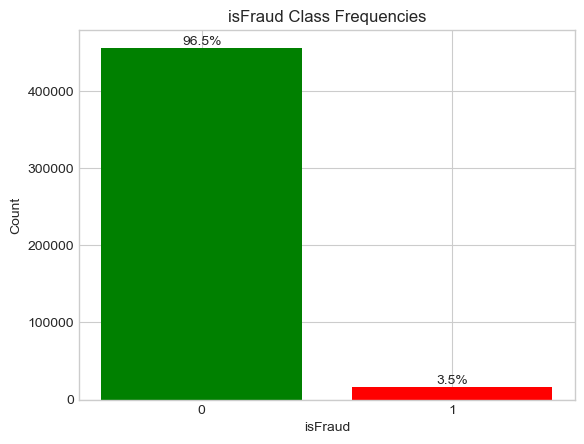

In [5]:
print("Class distribution for 'isFraud':")
print(train_df['isFraud'].value_counts())
print("\nPercentage:")
print(train_df['isFraud'].value_counts(normalize=True))

counts = train_df['isFraud'].value_counts()
percentages = train_df['isFraud'].value_counts(normalize=True) * 100

colors = ['green', 'red'] 
bars = plt.bar(counts.index, counts.values, color=colors[:len(counts)])

plt.title('isFraud Class Frequencies')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.xticks([0, 1])

for bar, perc in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{perc:.1f}%', ha='center', va='bottom')

plt.show()

Separation of numerical and categorical features

In [6]:
categorical_features = [
    'ProductCD', 'P_emaildomain', 'R_emaildomain','DeviceType', 'DeviceInfo',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
    'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
    'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]
numerical_features = [col for col in train_df.columns if col not in categorical_features]

present_cat_cols = list(set(categorical_features) & set(train_df.columns)) # After Dropping Missing data.

# resumetable(train_df[categorical_features])[:15]

# Categorical Feature Analysis

The company providing the data has specified which features in the dataset are categorical.

We can basically divide the features we have into two main groups: Transaction and Identity.

**Categorical features under Transaction**:

ProductCD: Transaction product code.

card1–card6: Card type, card country, etc. card information.

addr1, addr2: Geographic address information.

P_emaildomain: Purchaser email domain.

R_emaildomain: Recipient email domain.

M1–M9: Matching statuses (cardholder–address match, etc.)


**Categorical attributes under Identity**: 

DeviceType: Type of device used in the transaction.

DeviceInfo: Device information (model, manufacturer, etc.)

id_12–id_38: Network connection, browser information, and various session attributes.

---

It seems that some features specified as categorical have very high cardinality. These features will either be examined as numerical features or excluded from the study.

In [7]:
cardinality_threshold = 15
low_cardinality = [col for col in present_cat_cols if train_df[col].nunique() <= cardinality_threshold]
high_cardinality = [col for col in present_cat_cols if train_df[col].nunique() > cardinality_threshold]

categorical_features = low_cardinality
cardinality_features = high_cardinality # excluded

Similar groups have similar names in the categorical_features list. We can examine these groups among themselves.

In [8]:
# card_features = [col for col in train_df[categorical_features].columns if col.startswith('card')]
# cat_id_features = [col for col in train_df[categorical_features].columns if col.startswith('id_')]
# M_features = [col for col in train_df[categorical_features].columns if col.startswith('M') and len(col) == 2]
# kalan = card_features + cat_id_features + M_features
# indep_cat_features = [col for col in train_df[categorical_features].columns if col not in kalan ]


In [9]:
# len(categorical_features) == len(card_features) + len(cat_id_features) + len(M_features) + len(indep_cat_features)

We know that the card3 and card5 variables are categorical. Some studies have shown that classifying subcategories with very low frequencies as “Others” has a positive effect on the result.

On the other hand, it is not appropriate to examine the car1 and card2 features as categorical.

Additionally, we focus on extracting meaning from as much of our categorical data as possible. To this end, I have written some functions: 

**Feature Engineering for categerical columns**

1. **clean_email_domains**
Consolidates email domains (P_emaildomain and R_emaildomain) into major provider categories
Maps various domain extensions (e.g., gmail.com, googlemail.com) to their parent companies (google, microsoft, yahoo, apple, etc.)
Reduces cardinality by grouping similar domains under common provider names
Helps identify patterns related to email service providers rather than specific domain variations.

2. **analyze_email_match**
Creates a new feature called email_match that compares purchaser and recipient email domains
Assigns three possible values:
'Match': Both emails exist and use the same provider
'Different': Both emails exist but use different providers
'Unknown/Missing': One or both email fields are missing
This feature can indicate fraud risk, as mismatched or missing email pairs may signal suspicious transactions

3. **consolidate_device_info**
Standardizes device-related features (id_30 for OS and DeviceInfo for device details)
Groups operating systems and device types into broader categories (e.g., Windows, iOS, Android, Samsung, etc.)
Reduces high cardinality in device information by consolidating variations into main device families
Improves model generalization by focusing on device categories rather than specific models

In [10]:
def apply_feature_engineering(df, is_train=True, card3_rare=None, card5_rare=None):
    """
    Feature engineering pipeline - train ve test için aynı dönüşümleri uygular.
    
    Args:
        df: DataFrame
        is_train: True ise rare kategorileri öğrenir, False ise verilen listeleri kullanır
        card3_rare: Test için kullanılacak rare card3 kategorileri
        card5_rare: Test için kullanılacak rare card5 kategorileri
    
    Returns:
        df, card3_rare, card5_rare
    """
    df = df.copy()
    
    # Card3/Card5 gruplama
    if is_train:
        valid_card3 = df['card3'].value_counts()
        card3_rare = valid_card3[valid_card3 < 200].index.tolist()
        
        valid_card5 = df['card5'].value_counts()
        card5_rare = valid_card5[valid_card5 < 300].index.tolist()
    
    df.loc[df['card3'].isin(card3_rare), 'card3'] = "Others"
    df.loc[df['card5'].isin(card5_rare), 'card5'] = "Others"
    
    # Diğer dönüşümler
    df = (df
        .pipe(clean_email_domains)
        .pipe(analyze_email_match)
        .pipe(consolidate_device_info))
    
    df = analyze_time_categories(df)
    
    # Screen resolution
    if 'id_33' in df.columns:
        resolution_split = df['id_33'].astype(str).str.split('x', expand=True)
        if resolution_split.shape[1] == 2:
            df['screen_width'] = pd.to_numeric(resolution_split[0], errors='coerce')
            df['screen_height'] = pd.to_numeric(resolution_split[1], errors='coerce')
            df['total_pixels'] = df['screen_width'] * df['screen_height']
            df['aspect_ratio'] = df['screen_width'] / df['screen_height']
    
    return df, card3_rare, card5_rare

In [11]:
train_df, card3_rare, card5_rare = apply_feature_engineering(train_df, is_train=True)
test_df, _, _ = apply_feature_engineering(test_df, is_train=False, 
                                           card3_rare=card3_rare, 
                                           card5_rare=card5_rare)

* Filling in missing values.
* Target Encoding, Frequency Encoding.
* Scaling/Normalization.
* ..

When applying these operations, we must ensure that they are learned only from the training data.

---

Elimizdeki veri İşlem tarafnda zamansal olduğu için buna dayalı özellikler analiz edilmelidir. Bu amaçla analyze_time_categories kullanılır : 

Purpose: Extracts temporal features from the TransactionDT column and analyzes fraud patterns across different time periods.

What it does:

* Creates hour feature: Extracts the hour of day (0-23) from transaction timestamp.
* Creates day_of_week feature: Extracts the day of week (0-6) from transaction timestamp.
* Generates visualizations showing transaction volume and fraud rate patterns across hours and days Uses deterministic mathematical transformations (modulo operations) on the timestamp.

When deriving features, no statistics are learned from the existing data; deterministic transformations are performed. 
Therefore, the function does not have the data leakage risk. It is only important that the same process is applied to the test data! 

In [12]:
len(categorical_features)

24

### Categorical Feature Importance Test Before Modeling

Elimizdeki kategorik verileri başlangıçta kardinalitesi düşük ve yüksek olacak şekilde ayırdık. Yüksek kardinaliteye sahip bazı özellikleri çeşitli feature engineering yöntemleriyle kullanılabilir şekilde dönüştürdük .Elimizdeki tüm kategorik özelliklere bir bakalım.

In [13]:
card_features = list(set([col for col in categorical_features if col.startswith('card')] + ["card3", "card5"]))
cat_id_features = [col for col in categorical_features if col.startswith('id_')]
M_features = [col for col in categorical_features if col.startswith('M') and len(col) == 2]

excluded_features = card_features + cat_id_features + M_features
indep_cat_features = [col for col in categorical_features if col not in excluded_features]

added_features = [
    'P_emaildomain_bin', 'R_emaildomain_bin', 'email_match',
    'OS_type', 'Device_name', 'hour', 'day_of_week' , 'screen_width' , 'screen_height', 'total_pixels' , 'aspect_ratio'
]
added_features = [col for col in added_features if col in train_df.columns]

categorical_features = excluded_features +  indep_cat_features + added_features

print("Feature Groups Summary:")
print(f"  Card Features: {len(card_features)} -> {card_features}")
print(f"  ID Features: {len(cat_id_features)} -> {cat_id_features}")
print(f"  M Features: {len(M_features)} -> {M_features}")
print(f"  Independent Features: {len(indep_cat_features)} -> {indep_cat_features}")
print(f"  Added Features: {len(added_features)} -> {added_features}")
print(f"\nTotal Categorical Features: {len(card_features + cat_id_features + M_features + indep_cat_features + added_features)}")

Feature Groups Summary:
  Card Features: 4 -> ['card6', 'card3', 'card5', 'card4']
  ID Features: 11 -> ['id_38', 'id_28', 'id_36', 'id_34', 'id_29', 'id_35', 'id_16', 'id_15', 'id_12', 'id_32', 'id_37']
  M Features: 9 -> ['M2', 'M6', 'M5', 'M7', 'M8', 'M3', 'M9', 'M1', 'M4']
  Independent Features: 2 -> ['ProductCD', 'DeviceType']
  Added Features: 11 -> ['P_emaildomain_bin', 'R_emaildomain_bin', 'email_match', 'OS_type', 'Device_name', 'hour', 'day_of_week', 'screen_width', 'screen_height', 'total_pixels', 'aspect_ratio']

Total Categorical Features: 37


We need to decide which features are meaningful for us. 

What does the **cat_binary_test** function do? 
* Tests relationship between categorical features and binary target (isFraud)
* Uses Chi-Square Test for statistical significance
* Calculates practical importance based on fraud rate differences

**Test Logic** : 

**Chi-Square Test**:
* Null Hypothesis (H0): Feature and target are independent (no relationship)
* Alternative Hypothesis (H1): Feature and target are dependent (relationship exists)
* p-value < 0.05: Reject H0 → Statistically significant relationship (0.05 is default it can be change)
* p-value ≥ 0.05: Cannot reject H0 → No significant relationship

Key Metrics:

* Rate_Diff: Max fraud rate - Min fraud rate across categories
    * Shows how much fraud risk varies between different values
    * Higher = more discriminative power
    * Overall_Fraud_Rate: Baseline fraud rate (~3.5%) , fix  for all.

Decision Criteria : 
* The function uses two info : p_value,  rate_diff , frequency.
* The “Keep” column can be used to make a decision, but this is only a recommendation.

In [14]:
for col in train_df.select_dtypes(include=['int8', 'int16']).columns:
    train_df[col] = train_df[col].astype('int32')

for col in train_df.select_dtypes(include=['float16', 'float32']).columns:
    train_df[col] = train_df[col].astype('float64')

results_card = cat_binary_test(train_df, card_features, target='isFraud')
results_m = cat_binary_test(train_df, M_features, target='isFraud')
results_indep = cat_binary_test(train_df, indep_cat_features, target='isFraud')
results_engineered = cat_binary_test(train_df, added_features, target='isFraud')

all_results = pd.concat([
    results_card.assign(Group='Card'),
    results_m.assign(Group='M'),
    results_indep.assign(Group='Independent'),
    results_engineered.assign(Group='Engineered')
], ignore_index=True)

features_to_keep = all_results[all_results['Keep'] == True]['Feature'].tolist()
features_to_drop = all_results[all_results['Keep'] == False]['Feature'].tolist()
print(f"Features to KEEP: {len(features_to_keep)}")
print(f"Features to DROP: {len(features_to_drop)}")
print(f"features_to_drop list: {features_to_drop}")

print(f"{len(categorical_features)} categorical features retained for encoding")

# Apply the filtering
# categorical_features = features_to_keep

Features to KEEP: 21
Features to DROP: 5
features_to_drop list: ['M1', 'M6', 'M8', 'M7', 'day_of_week']
37 categorical features retained for encoding


NOT : Kategorik özellikleri bu şekilde drop etmek mantıklı olmayabilir mutlaka bir referans ile yapılmalıdır ! yani kesin değişecek bir kısım burası.

# Visualization for Categorical Features

In [15]:
# fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# for i, col in enumerate(['card3', 'card5']):
#     top_categories = train_df[col].astype(str).value_counts().head(10).index
    
#     plot_data = train_df[train_df[col].astype(str).isin(top_categories)]
    

#     rate_df = plot_data.groupby(col)['isFraud'].mean().reset_index()
#     rate_df.columns = [col, 'FraudRate']
#     rate_df['FraudRate'] = rate_df['FraudRate'] * 100 
#     rate_df = rate_df.sort_values(by='FraudRate', ascending=False)
    
#     sns.barplot(
#         x=col, 
#         y='FraudRate', 
#         data=rate_df, 
#         palette='pastel', 
#         ax=axes[i],
#         edgecolor='white'
#     )
    
#     axes[i].set_title(f'{col} Highest Risk Categories', fontsize=14)
#     axes[i].set_ylabel('Fraud Rate (%)')
#     axes[i].tick_params(axis='x', rotation=45)

# plt.tight_layout()
# plt.show()

In [16]:
# print("\n--- ProductCD ---")
# plot_categorical_analysis(train_df, 'ProductCD')

# print("\n--- card4 ---")
# plot_categorical_analysis(train_df, 'card4')

# print("\n--- card6 ---")
# plot_categorical_analysis(train_df, 'card6')

# # Email Domain Features
# print("P_emaildomain unique values:", train_df['P_emaildomain'].nunique())
# print("P_emaildomain_bin unique values:", train_df['P_emaildomain_bin'].nunique())

# print("\n--- Purchaser Email Domain ---")
# plot_categorical_analysis(train_df, 'P_emaildomain_bin')

# print("\n--- Recipient Email Domain ---")
# plot_categorical_analysis(train_df, 'R_emaildomain_bin')

# print("\n--- Email Match Status ---")
# plot_categorical_analysis(train_df, 'email_match')

# print("\n--- Operating System Type ---")
# plot_categorical_analysis(train_df, 'OS_type')

# print("\n--- Device Brand ---")
# plot_categorical_analysis(train_df, 'Device_name')

# print("\n--- Screen Resolution Analysis ---")
# analyze_screen_resolution(train_df)

Test sonuçlarıyla birlikte grafikler de görsel olarak değerlendirilebilir.

# Combination of Subcategories

The combination of subcategories from low-cardinality categorical features can yield higher fraud detection rates.

The main challenge here is that merging subcategories often leaves very few samples. We should set a threshold and be able to adjust it when necessary.

**scan_all_bivariate_combinations**

* Tests all pairwise combinations of categorical features
* Identifies subcategory pairs with highest fraud rates
* Returns top N riskiest combinations with statistics
* Used only on train data to learn patterns

**create_interaction_features_auto**

* Creates new features by combining high-risk category pairs
* Example: card4_x_ProductCD = "visa_W" (if both have high fraud)
* Filters combinations by minimum fraud rate threshold
* Applied to both train and test using learned patterns


In [17]:
categorical_to_scan = [
'card5', 'card3', 'card6','card4', 
'ProductCD','DeviceType', 
'P_emaildomain_bin', 'R_emaildomain_bin', 'email_match', 'OS_type', 'Device_name',
'id_12', 'id_13', 'id_15', 'id_17', 'id_19', 'id_20',
'id_23', 'id_28', 'id_29', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]

# bu fonksiyon sadece train e uygulanmalı.
top_combos = scan_all_bivariate_combinations(
    train_df, 
    categorical_to_scan, 
    min_samples=50,
    top_n=50
)

# Önceki özellikleri kaydet
train_df_before_interaction = train_df.copy()
cols_before = set(train_df_before_interaction.columns)

# trainden öğrenilen bilgiye dayanarak test setinde de uygulanabilir.
train_df = create_interaction_features_auto(
    train_df, 
    top_combos, 
    top_n=15,
    min_fraud_rate=20.0
)
test_df = create_interaction_features_auto(
    test_df, 
    top_combos, 
    top_n=15,
    min_fraud_rate=20.0
)

cols_after = set(train_df.columns)
interaction_features = list(cols_after - cols_before)

print(f"\nTotal interaction features created: {len(interaction_features)}")
if interaction_features:
    print(f" New features: {interaction_features}")
    categorical_features = categorical_features + interaction_features

else:
    print(" No interaction features created (threshold not met)")

Scanning 351 feature pairs...
Progress: 100/351 pairs processed...
Progress: 200/351 pairs processed...
Progress: 300/351 pairs processed...

Analysis complete! Found 325 valid combinations.
Top fraud rate: 98.4%
 card3_x_id_19                            | Fraud Rate:  98.36%
 card3_x_Device_name                      | Fraud Rate:  91.46%
 R_emaildomain_bin_x_id_33                | Fraud Rate:  89.47%
 P_emaildomain_bin_x_id_33                | Fraud Rate:  85.48%
 ProductCD_x_id_33                        | Fraud Rate:  85.48%
 P_emaildomain_bin_x_id_19                | Fraud Rate:  85.29%
 R_emaildomain_bin_x_id_19                | Fraud Rate:  85.29%
 id_28_x_id_33                            | Fraud Rate:  84.75%
 id_15_x_id_33                            | Fraud Rate:  84.62%
 id_29_x_id_33                            | Fraud Rate:  84.48%
 email_match_x_id_33                      | Fraud Rate:  82.46%
 id_19_x_id_20                            | Fraud Rate:  82.00%
 card6_x_id_33     

create_interaction_features_auto fonk una test_df i verdiğinde sadece bunu değiştiriyorsun kalan her şey aynı kalıyor. dönüşü de test_df e atıyorsun tabi ki.

In [18]:
cols_to_drop = [col for col in cardinality_features if col not in ['card3', 'card5']]

cols_to_drop = list(set([col for col in cols_to_drop if col in train_df.columns]))

# gereksiz verilerin temizlendiği hali.
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=[c for c in cols_to_drop if c in test_df.columns]) 

# Encoding

In [19]:
object_cols = train_df.select_dtypes(include=['object']).columns.tolist()

if 'isFraud' in object_cols:
    object_cols.remove('isFraud')

print(f"\nTotal columns to encode: {len(object_cols)}")
print(f"  - Original categorical: {len([c for c in object_cols if '_x_' not in c])}")
print(f"  - Interaction features: {len([c for c in object_cols if '_x_' in c])}")

train_df, label_encoders = apply_label_encoding(
    train_df, 
    columns=object_cols, 
    encoder_dict=None
)

test_df, _ = apply_label_encoding(test_df, columns=object_cols, encoder_dict=label_encoders)


# Verify encoding
remaining_objects = train_df.select_dtypes(include=['object']).columns.tolist()
if 'isFraud' in remaining_objects:
    remaining_objects.remove('isFraud')

print(f"Remaining object columns: {remaining_objects}")
print(f"Final train_df shape: {train_df.shape}")
print(f"Data types:\n{train_df.dtypes.value_counts()}")


Total columns to encode: 45
  - Original categorical: 30
  - Interaction features: 15
Remaining object columns: []
Final train_df shape: (472432, 435)
Data types:
float64    385
int32       50
Name: count, dtype: int64


# Numerical Analyisis

* TransactionAMT: transaction payment amount in USD
* dist1,dist2: some distance information
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: time delta, such as days between the previous transactions, etc.
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
* Transaction id: Id related to the transaction

In [20]:
v_cols = [col for col in train_df[numerical_features].columns if col.startswith('V')] 
c_cols = [col for col in train_df[numerical_features].columns if col.startswith('C')]
d_cols = [col for col in train_df[numerical_features].columns if col.startswith('D')]
id_cols = [col for col in train_df[numerical_features].columns if col.startswith('id_')]

grouped_cols = set(v_cols + c_cols + d_cols + id_cols) # bunlardan olmayanları bulmak için

indep_cols = [col for col in train_df[numerical_features].columns if col not in grouped_cols]

In [21]:
train_df.shape[1] - (len(v_cols) + len(c_cols)  + len(d_cols)+ len(id_cols)) # bu listeler dışında kalan 14 tane özellik var.

58

In [22]:
indep_cols

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'dist1',
 'dist2']

V Columns

In [23]:
# v_missing = train_df[v_cols].isnull()

# missing_rates = v_missing.mean().sort_values(ascending=False)

# plt.figure(figsize=(20, 6))
# missing_rates.plot(kind='bar')
# plt.title('V Sütunları Missing Rates')
# plt.ylabel('Missing Rate')
# plt.xlabel('V Columns')
# plt.axhline(0.5, color='red', linestyle='--', label='50% threshold')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [24]:
v_pattern_groups = group_by_missing_pattern(train_df, v_cols)

print("Exact Missing-Pattern Grouping Summary")
print("--------------------------------------")
print(f"Total V columns: {len(v_cols)}")
print(f"Unique missing patterns: {len(v_pattern_groups)}\n")

representative_v = []

for pattern_id, info in v_pattern_groups.items():
    group_cols = info['columns']

    if len(group_cols) == 1:
        representative_v.extend(group_cols)
        continue

    ks_res = test_feature_discrimination(train_df, group_cols, test='ks')

    if not ks_res.empty:
        best = ks_res.iloc[0]['Feature']
        representative_v.append(best)

print("Selected Representatives Summary")
print("--------------------------------")
print(f"Original V columns: {len(v_cols)}")
print(f"Selected representatives: {len(representative_v)}")
print(f"Reduction: {(1 - len(representative_v)/len(v_cols)) * 100:.1f}%")

# V sütunlarını filtrele - HEM TRAIN HEM TEST
cols_to_keep = train_df.columns.difference(v_cols).union(pd.Index(representative_v))
train_df = train_df[cols_to_keep]
test_df = test_df[[c for c in cols_to_keep if c in test_df.columns]]

# v_cols listesini güncelle
v_cols = [col for col in train_df.columns if col.startswith('V')]

print(f"\nFinal shapes:")
print(f"  Train: {train_df.shape}")
print(f"  Test: {test_df.shape}")

Exact Missing-Pattern Grouping Summary
--------------------------------------
Total V columns: 339
Unique missing patterns: 14

Selected Representatives Summary
--------------------------------
Original V columns: 339
Selected representatives: 14
Reduction: 95.9%

Final shapes:
  Train: (472432, 110)
  Test: (118108, 110)


In [25]:
def get_correlation_groups(df, columns, threshold=0.95):
    """
    Yüksek korelasyonlu özellikleri gruplar.
    
    Args:
        df: DataFrame
        columns: Korelasyon hesaplanacak sütunlar
        threshold: Korelasyon eşiği (default 0.95)
    
    Returns:
        dict: {grup_id: [col1, col2, ...], ...}
    """
    # Sadece mevcut kolonları al
    cols = [c for c in columns if c in df.columns]
    if len(cols) < 2:
        return {0: cols}
    
    corr_matrix = df[cols].corr().abs()
    
    # Union-Find için grup ataması
    groups = {col: col for col in cols}  # Her kolon kendi grubunun lideri
    
    def find(x):
        if groups[x] != x:
            groups[x] = find(groups[x])
        return groups[x]
    
    def union(x, y):
        px, py = find(x), find(y)
        if px != py:
            groups[px] = py
    
    # Yüksek korelasyonlu çiftleri birleştir
    for i, col1 in enumerate(cols):
        for col2 in cols[i+1:]:
            if corr_matrix.loc[col1, col2] >= threshold:
                union(col1, col2)
    
    # Grupları oluştur
    result = {}
    for col in cols:
        leader = find(col)
        if leader not in result:
            result[leader] = []
        result[leader].append(col)
    
    # Dict key'lerini sıralı hale getir
    return {i: v for i, (k, v) in enumerate(result.items())}


def select_representatives_by_ks(df, groups, target='isFraud'):
    """
    Her gruptan KS testi ile en ayırt edici özelliği seçer.
    
    Args:
        df: DataFrame
        groups: get_correlation_groups çıktısı
        target: Hedef değişken
    
    Returns:
        representatives: Seçilen özellik listesi
        details: Detaylı sonuçlar
    """
    from scipy.stats import ks_2samp
    
    representatives = []
    details = []
    
    fraud = df[df[target] == 1]
    non_fraud = df[df[target] == 0]
    
    for group_id, cols in groups.items():
        if len(cols) == 1:
            representatives.append(cols[0])
            details.append({'group': group_id, 'selected': cols[0], 'ks_stat': None, 'members': cols})
            continue
        
        best_col = None
        best_ks = -1
        
        for col in cols:
            try:
                f_vals = fraud[col].dropna()
                nf_vals = non_fraud[col].dropna()
                
                if len(f_vals) > 10 and len(nf_vals) > 10:
                    ks_stat, _ = ks_2samp(f_vals, nf_vals)
                    if ks_stat > best_ks:
                        best_ks = ks_stat
                        best_col = col
            except:
                continue
        
        if best_col:
            representatives.append(best_col)
            details.append({'group': group_id, 'selected': best_col, 'ks_stat': best_ks, 'members': cols})
    
    return representatives, details

Before correlation grouping:
  C columns: 14
  V columns: 14

C columns: 14 -> 5 (correlation grouping)
V columns: 14 -> 14 (correlation grouping)

After correlation grouping:
  Train shape: (472432, 101)
  Test shape: (118108, 101)


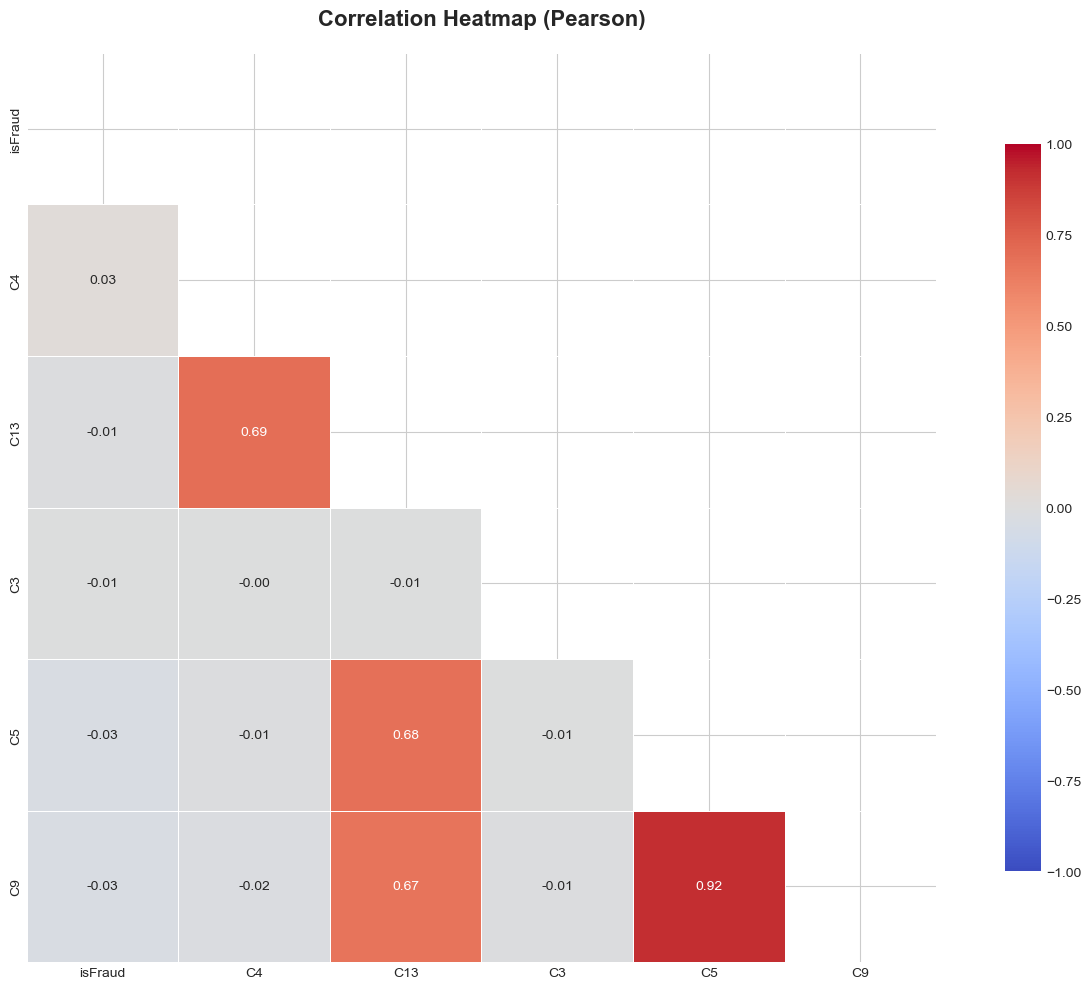

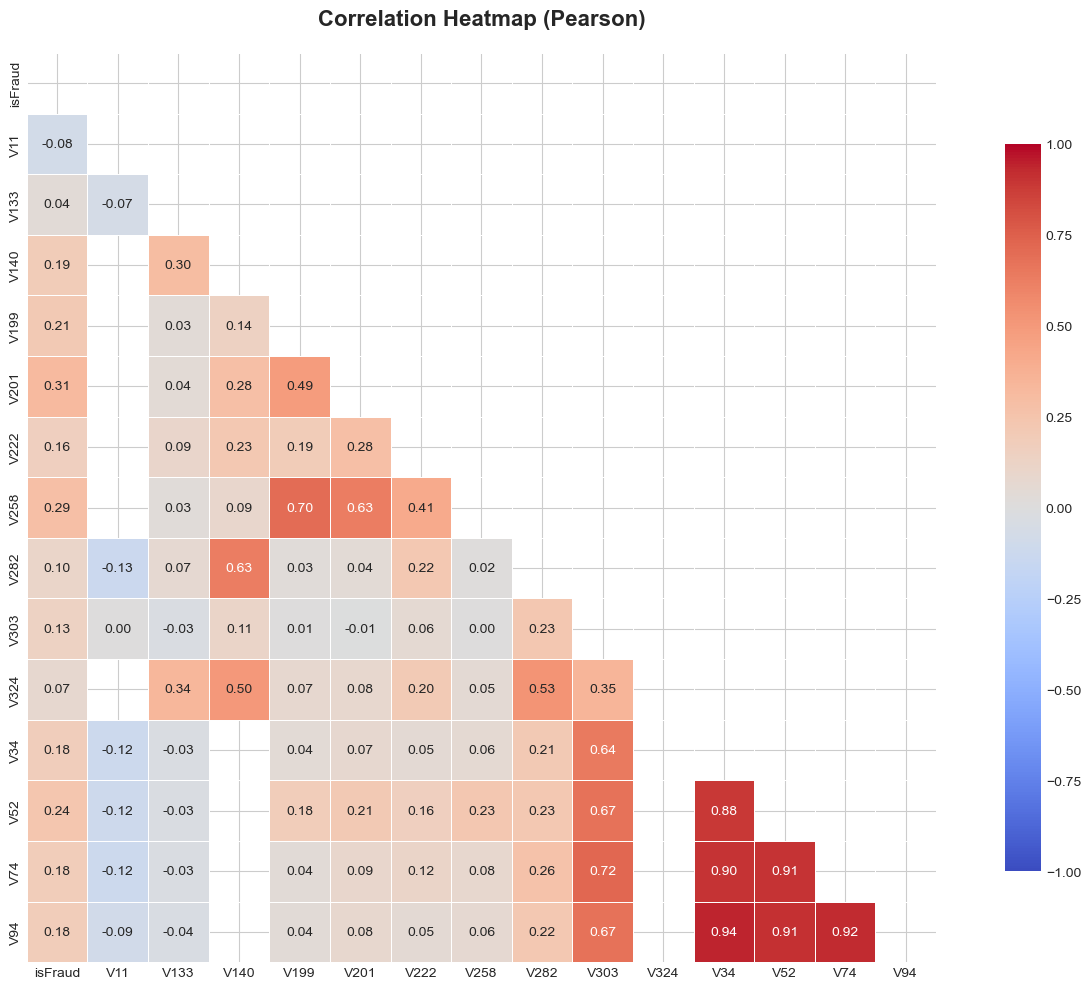

In [26]:
c_cols_current = [col for col in train_df.columns if col.startswith('C')]
v_cols_current = [col for col in train_df.columns if col.startswith('V')]

print(f"Before correlation grouping:")
print(f"  C columns: {len(c_cols_current)}")
print(f"  V columns: {len(v_cols_current)}")

# C kolonları için gruplama
if len(c_cols_current) > 1:
    c_groups = get_correlation_groups(train_df, c_cols_current, threshold=0.95)
    c_repr, c_details = select_representatives_by_ks(train_df, c_groups)
    print(f"\nC columns: {len(c_cols_current)} -> {len(c_repr)} (correlation grouping)")
else:
    c_repr = c_cols_current

# V kolonları için gruplama  
if len(v_cols_current) > 1:
    v_groups = get_correlation_groups(train_df, v_cols_current, threshold=0.95)
    v_repr, v_details = select_representatives_by_ks(train_df, v_groups)
    print(f"V columns: {len(v_cols_current)} -> {len(v_repr)} (correlation grouping)")
else:
    v_repr = v_cols_current

# Tutulacak tüm kolonlar
cols_to_remove = set(c_cols_current + v_cols_current) - set(c_repr + v_repr)
cols_to_keep = [c for c in train_df.columns if c not in cols_to_remove]

train_df = train_df[cols_to_keep]
test_df = test_df[[c for c in cols_to_keep if c in test_df.columns]]

print(f"\nAfter correlation grouping:")
print(f"  Train shape: {train_df.shape}")
print(f"  Test shape: {test_df.shape}")

# Heatmap (opsiyonel)
if len(c_repr) > 1:
    correlation_heatmap(train_df, columns=c_repr)
if len(v_repr) > 1:
    correlation_heatmap(train_df, columns=v_repr)

In [27]:
categorical_final = {
    'card': ['card3', 'card4', 'card5', 'card6'],
    'M': [col for col in train_df.columns if col.startswith('M') and len(col) == 2],
    'id': [col for col in train_df.columns if col.startswith('id_') and col in object_cols],
    'engineered': ['P_emaildomain_bin', 'R_emaildomain_bin', 'email_match', 
                   'OS_type', 'Device_name', 'ProductCD', 'DeviceType'],
    'interaction': [col for col in train_df.columns if '_x_' in col],
    'time': ['hour', 'day_of_week']
}


categorical_features_final = []
for group, cols in categorical_final.items():
    categorical_features_final.extend([c for c in cols if c in train_df.columns])

print("=== CATEGORICAL FEATURES ===")
for group, cols in categorical_final.items():
    present = [c for c in cols if c in train_df.columns]
    print(f"  {group}: {len(present)} features")
print(f"  TOTAL: {len(categorical_features_final)}")

# --- NUMERICAL FEATURES ---
numerical_final = {
    'V': [col for col in train_df.columns if col.startswith('V')],
    'C': [col for col in train_df.columns if col.startswith('C')],
    'D': [col for col in train_df.columns if col.startswith('D')],
    'screen': ['screen_width', 'screen_height', 'total_pixels', 'aspect_ratio'],
    'transaction': ['TransactionAmt', 'TransactionDT'],
    'other': ['dist1', 'dist2']
}

# Flat list
numerical_features_final = []
for group, cols in numerical_final.items():
    numerical_features_final.extend([c for c in cols if c in train_df.columns])

print("\n=== NUMERICAL FEATURES ===")
for group, cols in numerical_final.items():
    present = [c for c in cols if c in train_df.columns]
    print(f"  {group}: {len(present)} features")
print(f"  TOTAL: {len(numerical_features_final)}")

# --- ALL FEATURES ---
all_features = categorical_features_final + numerical_features_final
target = 'isFraud'

# Kontrol
print(f"\n=== SUMMARY ===")
print(f"Categorical: {len(categorical_features_final)}")
print(f"Numerical: {len(numerical_features_final)}")
print(f"Total Features: {len(all_features)}")
print(f"Target: {target}")

# Train/Test shape kontrolü
missing_in_train = [c for c in all_features if c not in train_df.columns]
missing_in_test = [c for c in all_features if c not in test_df.columns]

if missing_in_train:
    print(f"\n Train'de eksik: {missing_in_train}")
if missing_in_test:
    print(f"\n Test'te eksik: {missing_in_test}")

# Final DataFrames
X_train = train_df[all_features]
y_train = train_df[target]
X_test = test_df[[c for c in all_features if c in test_df.columns]]
y_test = test_df[target]

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

=== CATEGORICAL FEATURES ===
  card: 4 features
  M: 9 features
  id: 15 features
  engineered: 7 features
  interaction: 15 features
  time: 2 features
  TOTAL: 52

=== NUMERICAL FEATURES ===
  V: 14 features
  C: 5 features
  D: 18 features
  screen: 4 features
  transaction: 2 features
  other: 2 features
  TOTAL: 45

=== SUMMARY ===
Categorical: 52
Numerical: 45
Total Features: 97
Target: isFraud

X_train shape: (472432, 97)
X_test shape: (118108, 97)


In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# ============================================
# 1. XGBOOST FEATURE IMPORTANCE
# ============================================

def quick_xgb_importance(X_train, y_train, X_test, y_test, top_n=30):
    """
    XGBoost ile hızlı feature importance analizi.
    
    Args:
        X_train, y_train: Eğitim verisi
        X_test, y_test: Test verisi
        top_n: Gösterilecek özellik sayısı
    
    Returns:
        importance_df: Sıralı feature importance DataFrame
    """
    # Fraud oranına göre scale_pos_weight
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        eval_metric='auc',
        early_stopping_rounds=10,
        verbosity=0
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    # Feature importance (3 farklı metrik)
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'gain': model.feature_importances_,  # Default: gain
    })
    
    # Booster'dan diğer metrikleri al
    booster = model.get_booster()
    
    weight_imp = booster.get_score(importance_type='weight')
    cover_imp = booster.get_score(importance_type='cover')
    
    importance_df['weight'] = importance_df['feature'].map(weight_imp).fillna(0)
    importance_df['cover'] = importance_df['feature'].map(cover_imp).fillna(0)
    
    # Normalize
    for col in ['gain', 'weight', 'cover']:
        if importance_df[col].sum() > 0:
            importance_df[col] = importance_df[col] / importance_df[col].sum() * 100
    
    importance_df = importance_df.sort_values('gain', ascending=False).reset_index(drop=True)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top N by Gain
    top_df = importance_df.head(top_n)
    axes[0].barh(range(len(top_df)), top_df['gain'].values)
    axes[0].set_yticks(range(len(top_df)))
    axes[0].set_yticklabels(top_df['feature'].values)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Importance (Gain %)')
    axes[0].set_title(f'Top {top_n} Features by XGBoost Gain')
    
    # Cumulative importance
    importance_df['cumulative'] = importance_df['gain'].cumsum()
    axes[1].plot(range(len(importance_df)), importance_df['cumulative'].values)
    axes[1].axhline(y=90, color='r', linestyle='--', label='90% threshold')
    axes[1].axhline(y=95, color='orange', linestyle='--', label='95% threshold')
    n_90 = (importance_df['cumulative'] <= 90).sum()
    n_95 = (importance_df['cumulative'] <= 95).sum()
    axes[1].axvline(x=n_90, color='r', linestyle=':', alpha=0.5)
    axes[1].axvline(x=n_95, color='orange', linestyle=':', alpha=0.5)
    axes[1].set_xlabel('Number of Features')
    axes[1].set_ylabel('Cumulative Importance (%)')
    axes[1].set_title(f'Cumulative Importance\n90%: {n_90} features, 95%: {n_95} features')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return importance_df, model


# ============================================
# 2. PERMUTATION IMPORTANCE (Alternatif)
# ============================================

def quick_permutation_importance(model, X_test, y_test, top_n=30):
    """
    Permutation importance - model-agnostic yöntem.
    Daha güvenilir ama daha yavaş.
    """
    perm_result = permutation_importance(
        model, X_test, y_test, 
        n_repeats=5, 
        random_state=42, 
        n_jobs=-1,
        scoring='roc_auc'
    )
    
    perm_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance_mean': perm_result.importances_mean,
        'importance_std': perm_result.importances_std
    }).sort_values('importance_mean', ascending=False).reset_index(drop=True)
    
    # Visualization
    plt.figure(figsize=(10, 8))
    top_perm = perm_df.head(top_n)
    plt.barh(range(len(top_perm)), top_perm['importance_mean'].values, 
             xerr=top_perm['importance_std'].values, capsize=3)
    plt.yticks(range(len(top_perm)), top_perm['feature'].values)
    plt.gca().invert_yaxis()
    plt.xlabel('Permutation Importance (AUC decrease)')
    plt.title(f'Top {top_n} Features by Permutation Importance')
    plt.tight_layout()
    plt.show()
    
    return perm_df


# ============================================
# 3. FEATURE IMPORTANCE KARŞILAŞTIRMASI
# ============================================

def compare_importance_methods(xgb_imp, perm_imp, top_n=20):
    """
    XGBoost ve Permutation importance sonuçlarını karşılaştır.
    """
    # Merge
    xgb_top = set(xgb_imp.head(top_n)['feature'])
    perm_top = set(perm_imp.head(top_n)['feature'])
    
    common = xgb_top & perm_top
    only_xgb = xgb_top - perm_top
    only_perm = perm_top - xgb_top
    
    print(f"=== Top {top_n} Feature Comparison ===")
    print(f"Common in both methods: {len(common)}")
    print(f"Only in XGBoost: {len(only_xgb)}")
    print(f"Only in Permutation: {len(only_perm)}")
    
    print(f"\n Common features: {sorted(common)}")
    
    # Rank correlation
    merged = xgb_imp[['feature', 'gain']].merge(
        perm_imp[['feature', 'importance_mean']], 
        on='feature'
    )
    merged['xgb_rank'] = merged['gain'].rank(ascending=False)
    merged['perm_rank'] = merged['importance_mean'].rank(ascending=False)
    
    correlation = merged['xgb_rank'].corr(merged['perm_rank'], method='spearman')
    print(f"\nSpearman Rank Correlation: {correlation:.3f}")
    
    return common, only_xgb, only_perm

In [ ]:
# Duplicate kontrolü
print("=== DUPLICATE CHECK ===")
from collections import Counter

feature_counts = Counter(all_features)
duplicates = {k: v for k, v in feature_counts.items() if v > 1}

if duplicates:
    print(f" DUPLICATE FEATURES FOUND: {duplicates}")
    
    # Duplicates'ları kaldır
    all_features_unique = list(dict.fromkeys(all_features))  # Sırayı koruyarak unique yap
    print(f"Before: {len(all_features)} features")
    print(f"After:  {len(all_features_unique)} features")
    
    # X_train ve X_test'i yeniden oluştur
    X_train = train_df[all_features_unique]
    X_test = test_df[[c for c in all_features_unique if c in test_df.columns]]
    
    all_features = all_features_unique
else:
    print(" No duplicates found")

print(f"\nFinal X_train shape: {X_train.shape}")
print(f"Final X_test shape: {X_test.shape}")


X_train_filled = X_train.fillna(-999)
X_test_filled = X_test.fillna(-999)


Dataset shape: (472432, 89)
Number of features: 89
Fraud rate: 3.51%

--- XGBoost Feature Importance ---


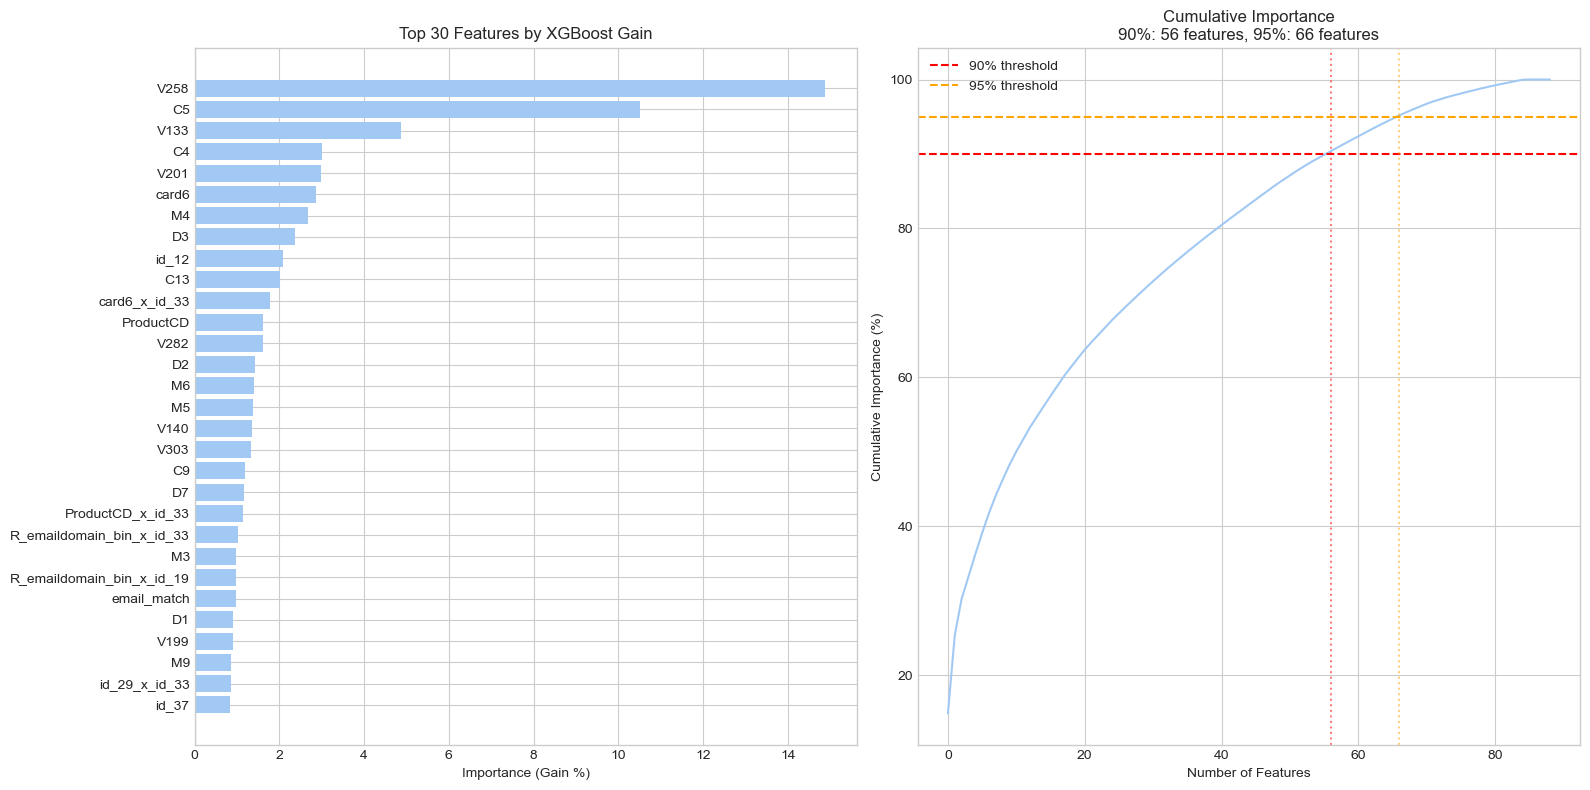


--- Permutation Importance ---


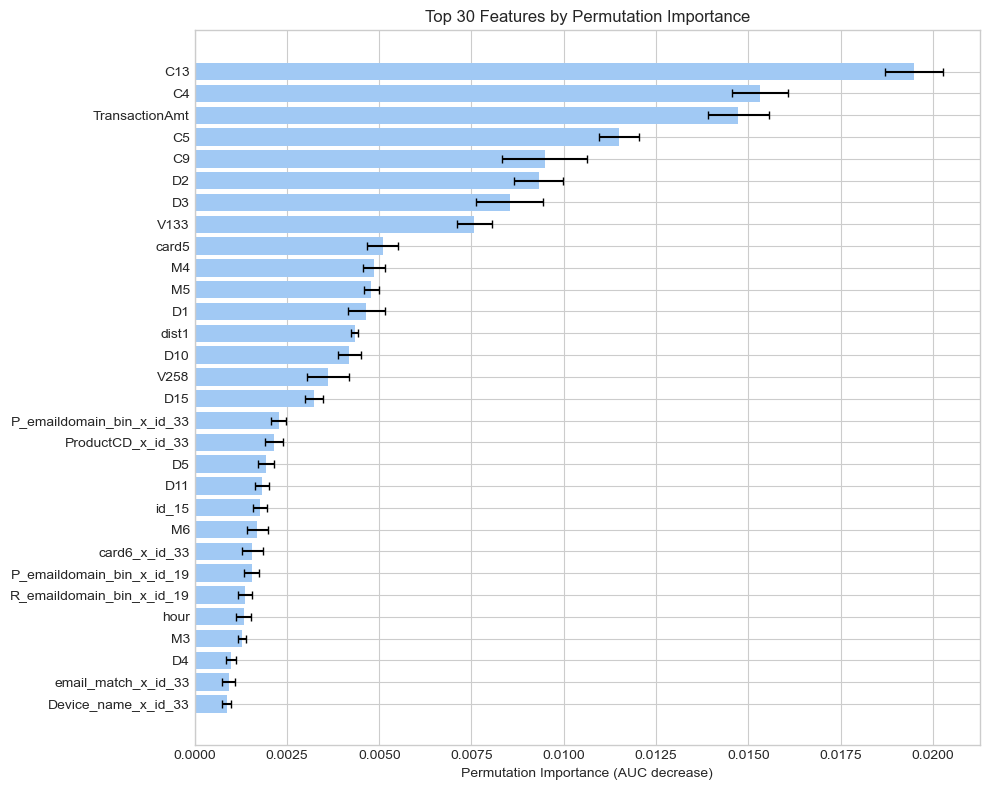


--- Method Comparison ---
=== Top 20 Feature Comparison ===
Common in both methods: 10
Only in XGBoost: 10
Only in Permutation: 10

 Common features: ['C13', 'C4', 'C5', 'C9', 'D2', 'D3', 'M4', 'M5', 'V133', 'V258']

Spearman Rank Correlation: 0.524

SUMMARY - RECOMMENDED FEATURES TO KEEP

Features needed for 90% importance: 57 / 89
Reduction: 36.0%

Top 10 Most Important Features:
  1. V258: 14.88%
  2. C5: 10.51%
  3. V133: 4.87%
  4. C4: 2.99%
  5. V201: 2.99%
  6. card6: 2.86%
  7. M4: 2.67%
  8. D3: 2.38%
  9. id_12: 2.10%
  10. C13: 2.02%

 Zero importance features (3): Can be safely removed
  ['id_16', 'id_29', 'M1']


In [30]:
# Missing value handling for XGBoost
X_train_filled = X_train.fillna(-999)
X_test_filled = X_test.fillna(-999)

print(f"\nDataset shape: {X_train_filled.shape}")
print(f"Number of features: {X_train_filled.shape[1]}")
print(f"Fraud rate: {y_train.mean()*100:.2f}%")

# 1. XGBoost Importance
print("\n--- XGBoost Feature Importance ---")
xgb_importance, xgb_model = quick_xgb_importance(
    X_train_filled, y_train, 
    X_test_filled, y_test,
    top_n=30
)

# 2. Permutation Importance (opsiyonel - daha yavaş)
print("\n--- Permutation Importance ---")
perm_importance = quick_permutation_importance(
    xgb_model, X_test_filled, y_test, 
    top_n=30
)

# 3. Karşılaştırma
print("\n--- Method Comparison ---")
common, only_xgb, only_perm = compare_importance_methods(
    xgb_importance, perm_importance, top_n=20
)

# 4. Sonuç özeti
print("\n" + "=" * 50)
print("SUMMARY - RECOMMENDED FEATURES TO KEEP")
print("=" * 50)

# 90% cumulative importance'a ulaşan özellikler
n_features_90 = (xgb_importance['gain'].cumsum() <= 90).sum() + 1
top_features = xgb_importance.head(n_features_90)['feature'].tolist()

print(f"\nFeatures needed for 90% importance: {n_features_90} / {len(xgb_importance)}")
print(f"Reduction: {(1 - n_features_90/len(xgb_importance))*100:.1f}%")

# Top 10 özellikleri göster
print(f"\nTop 10 Most Important Features:")
for i, row in xgb_importance.head(10).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['gain']:.2f}%")

# Zero importance features
zero_imp = xgb_importance[xgb_importance['gain'] == 0]['feature'].tolist()
if zero_imp:
    print(f"\n Zero importance features ({len(zero_imp)}): Can be safely removed")
    print(f"  {zero_imp[:10]}{'...' if len(zero_imp) > 10 else ''}")

In [31]:
zero_imp_features = ['id_16', 'id_29', 'M1']

# 90% cumulative importance'a ulaşan özellikler
top_features_90 = xgb_importance[xgb_importance['cumulative'] <= 90]['feature'].tolist()
if len(top_features_90) < len(xgb_importance):
    # 90'ı geçen ilk feature'ı da ekle
    top_features_90.append(xgb_importance.iloc[len(top_features_90)]['feature'])

print(f"Selected features: {len(top_features_90)}")
print(f"Removed (zero importance): {zero_imp_features}")

# Final feature set
selected_features = [f for f in top_features_90 if f not in zero_imp_features]

# Final X_train, X_test
X_train_final = X_train[selected_features]
X_test_final = X_test[[c for c in selected_features if c in X_test.columns]]

print(f"\nFinal shapes:")
print(f"  X_train: {X_train_final.shape}")
print(f"  X_test: {X_test_final.shape}")

Selected features: 57
Removed (zero importance): ['id_16', 'id_29', 'M1']

Final shapes:
  X_train: (472432, 57)
  X_test: (118108, 57)


In [32]:
train_df[selected_features + ['isFraud']].to_csv(DATA / "train_processed.csv", index=False)
test_df[[c for c in selected_features if c in test_df.columns] + ['isFraud']].to_csv(DATA / "test_processed.csv", index=False)